In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
subsDf = pd.read_csv("/content/drive/MyDrive/FODS__FP/Dataset/subsDf.csv", low_memory=False)

In [4]:
# Selecting relevant features for clustering
features_to_use = ['country', 'operator', 'service', 'source', 'status',
                   'success_billing']

In [5]:
# Filtering the dataset to include only the selected features
data_selected = subsDf[features_to_use]

In [6]:
# Handling missing values - filling with mode for categorical and median for numerical data
data_selected = data_selected.fillna({
    'country': data_selected['country'].mode()[0],
    'operator': data_selected['operator'].mode()[0],
    'service': data_selected['service'].mode()[0],
    'source': data_selected['source'].mode()[0],
    'status': data_selected['status'].median(),
    'success_billing': data_selected['success_billing'].median(),
})

In [7]:
# Preprocessing: OneHotEncoder for categorical features and StandardScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['status', 'success_billing']),
        ('cat', OneHotEncoder(), ['country', 'operator', 'service', 'source'])
    ])

In [8]:
# Converting categorical columns to string type to avoid mixed type issues during encoding
for col in ['country', 'operator', 'service', 'source']:
    data_selected[col] = data_selected[col].astype(str)

In [9]:
# Fitting and transforming the data
processed_data = preprocessor.fit_transform(data_selected)

In [10]:
# Checking the shape of the processed data
processed_data.shape

(308911, 39)

K-Means Clustering

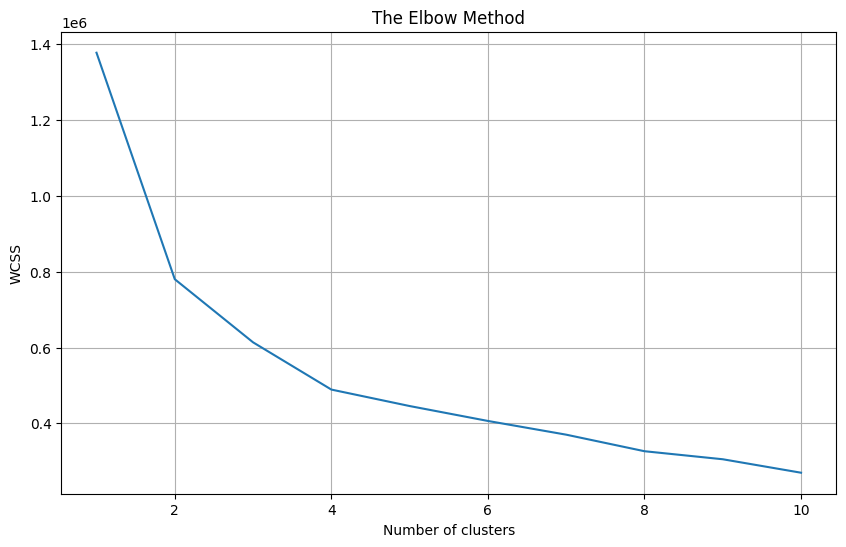

In [11]:
# Determining the optimal number of clusters using the Elbow Method for KMeans
wcss = []  # Within-Cluster-Sum-of-Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(processed_data)
    wcss.append(kmeans.inertia_)

# Plotting the results to observe 'The Elbow'
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Principal Component Analysis for dimensionality reduction

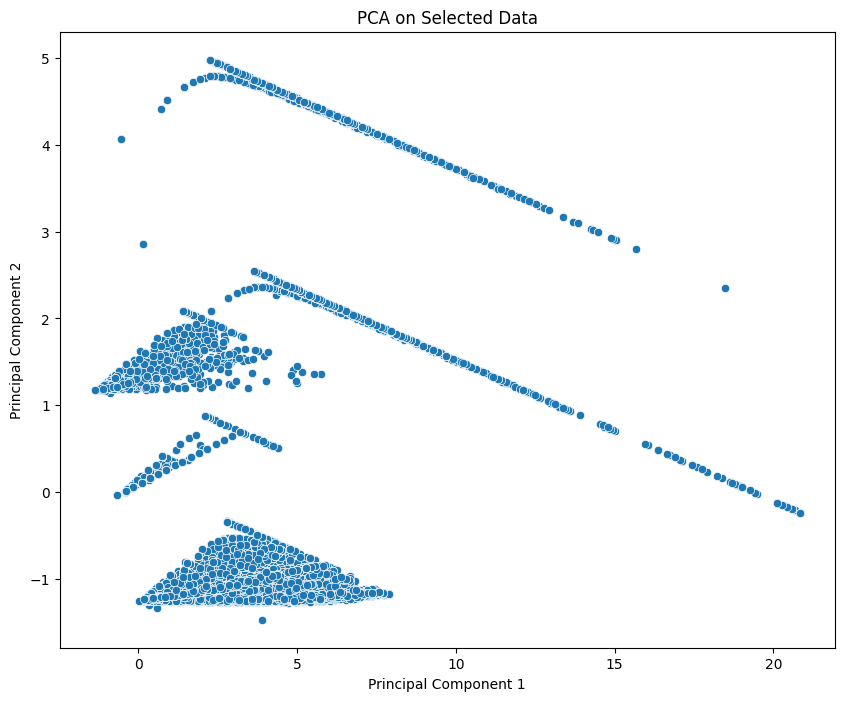

In [15]:
from sklearn.decomposition import PCA
import seaborn as sns

# PCA requires the data to be scaled, so we'll scale our data first
from sklearn.preprocessing import StandardScaler

selected_columns = ['status', 'success_billing', 'billing_success_rate', 'service rupiah']
cluster_data = subsDf[selected_columns]

# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Applying PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(scaled_data)

# Creating a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Plotting the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('PCA on Selected Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [16]:
# Calculating the Explained Variance Ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculating the Cumulative Explained Variance
cumulative_explained_variance = explained_variance_ratio.cumsum()

explained_variance_ratio, cumulative_explained_variance

(array([0.46830986, 0.33635069]), array([0.46830986, 0.80466055]))

Explained Variance Ratio:
Principal Component 1: Approximately 46.83% of the variance.
Principal Component 2: Approximately 33.64% of the variance.

Cumulative Explained Variance:
The first principal component alone captures about 46.83% of the total variance in the dataset.
The first two principal components together capture about 80.47% of the total variance.

**Gaussian Mixture Model**

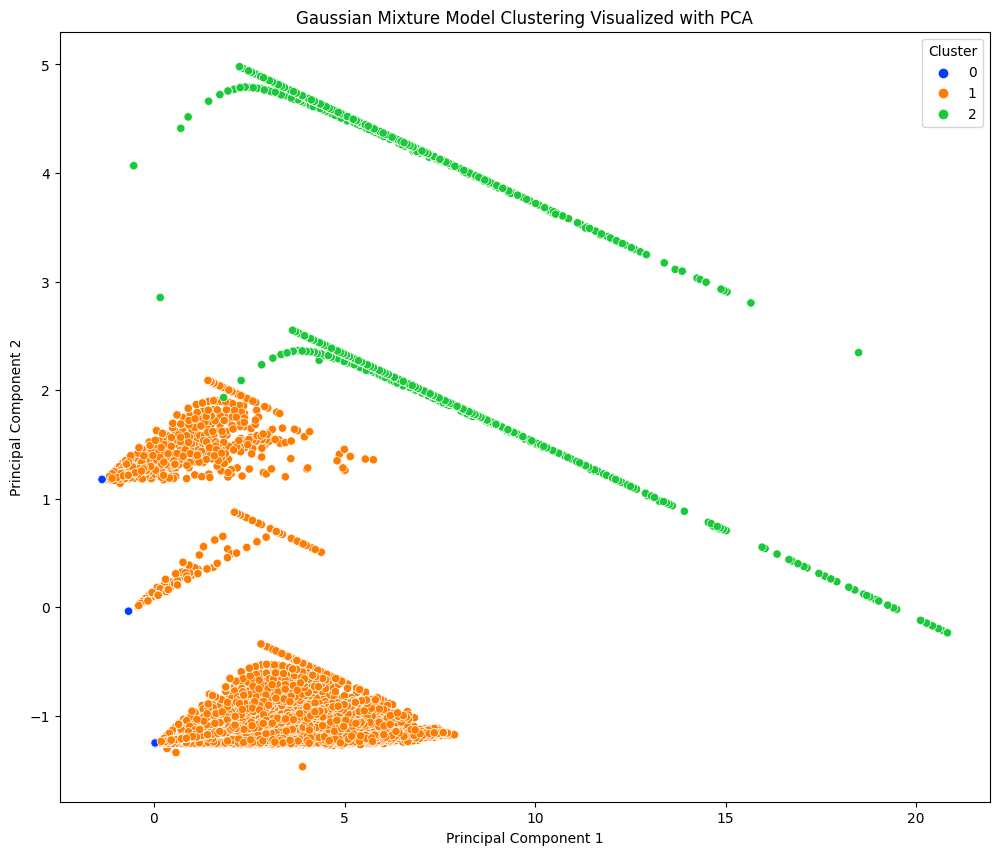

In [17]:
from sklearn.mixture import GaussianMixture

# Applying Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)  # Assuming 3 clusters for demonstration
gmm_labels = gmm.fit_predict(scaled_data)

# Adding the cluster labels to our PCA DataFrame
pca_df['GMM_Cluster'] = gmm_labels

# Plotting the GMM clustering results using PCA for visualization
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='GMM_Cluster', data=pca_df, palette='bright')
plt.title('Gaussian Mixture Model Clustering Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [18]:
# Calculating Bayesian Information Criterion and Akaike Information Criterion for the GMM model
bic = gmm.bic(scaled_data)
aic = gmm.aic(scaled_data)

bic, aic

(-7276092.455784626, -7276560.65135812)

Both BIC and AIC are lower (which is preferable), suggesting a good fit of the model to the data. Between the two, the lower the BIC or AIC value, the better the balance between the model's complexity and its fit to the data.

**Mean Shift algorithm**

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


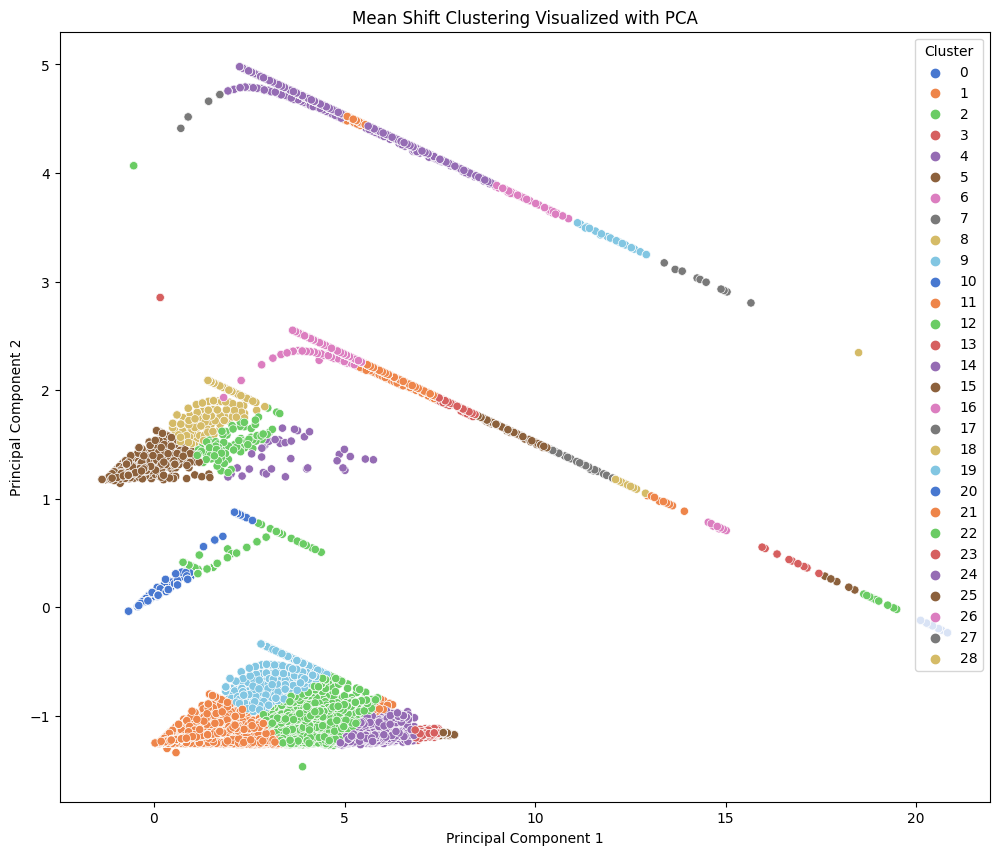

In [20]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Estimating the bandwidth for Mean Shift
bandwidth = estimate_bandwidth(scaled_data, quantile=0.2, n_samples=500)

# Applying Mean Shift
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_shift_labels = mean_shift.fit_predict(scaled_data)

# Adding the cluster labels to our PCA DataFrame
pca_df['MeanShift_Cluster'] = mean_shift_labels

# Plotting the Mean Shift clustering results using PCA for visualization
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='MeanShift_Cluster', data=pca_df, palette='muted')
plt.title('Mean Shift Clustering Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Calinski-Harabasz Index

In [23]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Calculating Calinski-Harabasz Index
calinski_harabasz_index = calinski_harabasz_score(scaled_data, mean_shift_labels)

calinski_harabasz_index

143489.88726122037

Calinski-Harabasz index value of 143489.88726122037 suggests that the Mean Shift clustering algorithm has produced clusters that are relatively well-separated and distinct.